# Comparative Analysis of Machine Learning Models for Raisin Variety Classification

**Author:** Rafhiromadoni Sopandi | **Domain:** Agriculture & Quality Control Automation
**Tech Stack:** Python, Scikit-Learn, Pandas, Seaborn

## 📌 Project Overview
Industri pengolahan pangan seringkali menghadapi tantangan dalam menyortir varietas produk yang mirip secara visual. Proyek ini bertujuan untuk membangun sistem klasifikasi otomatis untuk membedakan dua varietas kismis (*Kecimen* dan *Besni*) berdasarkan fitur morfologisnya.

## 🎯 Objective
Membandingkan performa dua algoritma klasifikasi (**K-Nearest Neighbors** dan **Random Forest**) untuk menentukan model terbaik yang dapat diimplementasikan dalam sistem penyortiran otomatis.

In [2]:
pip install ucimlrepo

## 1. Data Understanding & Preprocessing
Dataset terdiri dari 900 sampel dengan 7 fitur morfologis (Area, Perimeter, MajorAxisLength, dll).
Langkah preprocessing meliputi:
1.  **Data Cleaning:** Memeriksa missing values.
2.  **Feature Scaling:** Melakukan normalisasi data (MinMax/StandardScaler) karena algoritma seperti KNN sangat sensitif terhadap skala data.
3.  **Train-Test Split:** Membagi data menjadi 80% Training dan 20% Testing.

In [3]:
# --- IMPORT LIBRARY ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Sklearn Modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# --- LOAD DATASET ---
print("Sedang mengambil dataset Raisin dari UCI Repository...")
raisin = fetch_ucirepo(id=850)

# Konversi ke DataFrame
X = raisin.data.features
y = raisin.data.targets

# Gabungkan untuk keperluan EDA awal
df = pd.concat([X, y], axis=1)

print(f"Dataset Berhasil Dimuat! Dimensi: {df.shape}")
display(df.head())

Sedang mengambil dataset Raisin dari UCI Repository...
Dataset Berhasil Dimuat! Dimensi: (900, 8)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [4]:
# --- 1. HANDLING OUTLIERS (Metode IQR) ---
def remove_outliers(df):
    # Hanya kolom numerik yang dihitung outlier-nya
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Filter data
    condition = ~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[condition]

print(f"Jumlah data sebelum cleaning: {len(df)}")
df_clean = remove_outliers(df)
print(f"Jumlah data setelah cleaning: {len(df_clean)}")

# --- 2. PREPARATION (Split & Encode) ---
# Pisahkan Fitur dan Target kembali
X_clean = df_clean.drop('Class', axis=1)
y_clean = df_clean['Class']

# Encode Label (Kecimen/Besni -> 0/1)
le = LabelEncoder()
y_encoded = le.fit_transform(y_clean)
print(f"Kelas Label: {le.classes_}")

# Split Training & Testing (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_encoded, test_size=0.2, random_state=42)

# --- 3. SCALING (Penting untuk KNN) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData siap digunakan untuk modeling!")

Jumlah data sebelum cleaning: 900
Jumlah data setelah cleaning: 795
Kelas Label: ['Besni' 'Kecimen']

Data siap digunakan untuk modeling!


## 2. Model Benchmarking

Tahap ini membandingkan dua pendekatan algoritma:
* **Model A: K-Nearest Neighbors (KNN)** - *Instance-based learning* yang sederhana namun efektif untuk pola lokal.
* **Model B: Random Forest** - Dipilih karena kemampuannya menangani hubungan non-linear yang kompleks antar fitur morfologis dan lebih tahan terhadap overfitting dibandingkan Decision Tree tunggal.

In [5]:
# --- MODEL 1: K-NEAREST NEIGHBORS (KNN) ---
# Menggunakan K=5 sebagai standar awal
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

# --- MODEL 2: RANDOM FOREST (RF) ---
# Menggunakan parameter 'Skema 2' dari file ML Anda (n_estimators=300)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=42)
rf_model.fit(X_train_scaled, y_train) # RF sebenarnya tidak butuh scaling, tapi tidak masalah jika pakai data scaled
y_pred_rf = rf_model.predict(X_test_scaled)

print("Pelatihan kedua model selesai.")

Pelatihan kedua model selesai.


## 3. Performance Evaluation

Perbandingan hasil akurasi dan metrik evaluasi lainnya.

=== FINAL RESULT COMPARISON ===


,Model,Accuracy,F1-Score,Macro Avg
0,KNN (K=5),0.767296,0.773006,0.767148
1,Random Forest (300 Trees),0.805031,0.802548,0.805001


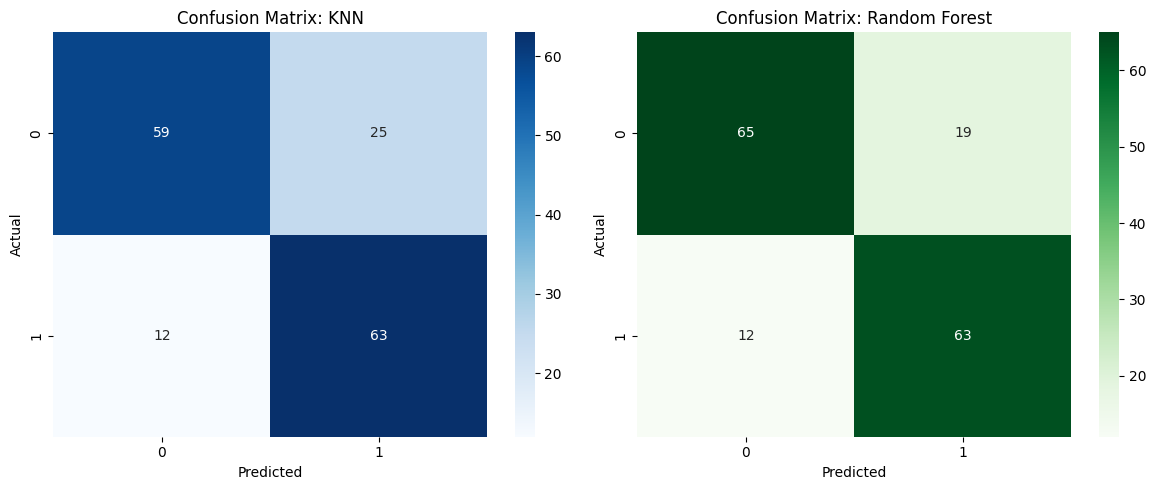

In [6]:
# --- FUNGSI EVALUASI ---
def get_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'Macro Avg': classification_report(y_true, y_pred, output_dict=True)['macro avg']['f1-score']
    }

# Hitung Metrik
metrics_knn = get_metrics(y_test, y_pred_knn, 'KNN (K=5)')
metrics_rf = get_metrics(y_test, y_pred_rf, 'Random Forest (300 Trees)')

# Buat DataFrame Perbandingan
df_comparison = pd.DataFrame([metrics_knn, metrics_rf])

# Tampilkan Tabel Hasil
print("=== FINAL RESULT COMPARISON ===")
display(df_comparison.style.highlight_max(axis=0, color='lightgreen'))

# --- VISUALISASI CONFUSION MATRIX ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot KNN
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix: KNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix: Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 4. Conclusion & Recommendation

Berdasarkan hasil eksperimen komparasi model klasifikasi varietas kismis:

1.  **Performance Champion:** Model **Random Forest** memberikan performa terbaik dengan akurasi sebesar **80.5%**, sedikit mengungguli model KNN yang mencapai **76.7%**. Meskipun selisihnya tipis, Random Forest konsisten lebih unggul di metrik F1-Score (0.802 vs 0.773).

2.  **Analisis Kesalahan (Error Analysis):** Dari Confusion Matrix, terlihat bahwa Random Forest melakukan kesalahan prediksi yang lebih sedikit (31 kesalahan) dibandingkan KNN (37 kesalahan). Ini menunjukkan bahwa model *ensemble* (gabungan banyak pohon keputusan) lebih teliti dalam membedakan fitur morfologis kismis yang ambigu dibandingkan metode jarak sederhana.

3.  **Rekomendasi Implementasi:** Untuk sistem *quality control* otomatis di industri, sangat disarankan menggunakan **Random Forest**. Selain akurasinya lebih tinggi, model ini tidak membebani memori saat *deployment* (karena tidak perlu menyimpan seluruh dataset pelatihan seperti KNN) dan lebih tahan (robust) terhadap variasi data baru di lapangan.